This notebook is designed to run in a IBM Watson Studio default runtime (NOT the Watson Studio Apache Spark Runtime as the default runtime with 1 vCPU is free of charge). Therefore, we install Apache Spark in local mode for test purposes only. Please don't use it in production.

In case you are facing issues, please read the following two documents first:

https://github.com/IBM/skillsnetwork/wiki/Environment-Setup

https://github.com/IBM/skillsnetwork/wiki/FAQ

Then, please feel free to ask:

https://coursera.org/learn/machine-learning-big-data-apache-spark/discussions/all

Please make sure to follow the guidelines before asking a question:

https://github.com/IBM/skillsnetwork/wiki/FAQ#im-feeling-lost-and-confused-please-help-me


If running outside Watson Studio, this should work as well. In case you are running in an Apache Spark context outside Watson Studio, please remove the Apache Spark setup in the first notebook cells.

In [1]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown('# <span style="color:red">'+string+'</span>'))


if ('sc' in locals() or 'sc' in globals()):
    printmd('<<<<<!!!!! It seems that you are running in a IBM Watson Studio Apache Spark Notebook. Please run it in an IBM Watson Studio Default Runtime (without Apache Spark) !!!!!>>>>>')


In [2]:
!pip install pyspark==2.4.5

In [3]:
try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
except ImportError as e:
    printmd('<<<<<!!!!! Please restart your kernel after installing Apache Spark !!!!!>>>>>')

In [4]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

Welcome to exercise one of week two of “Apache Spark for Scalable Machine Learning on BigData”. In this exercise you’ll read a DataFrame in order to perform a simple statistical analysis. Then you’ll rebalance the dataset. No worries, we’ll explain everything to you, let’s get started.

Let’s create a data frame from a remote file by downloading it:




In [88]:
from random import *
#create rdd
data1 = ([10],[10],[5],[6],[10],[10],[10],[10],[7],[4])
#rdd=sc.parallelize(data)
#rdd.count()
#rdd.take(10)
#mean value
#sum=rdd.sum()
#n=rdd.count()
#mean=sum/float(n)
#print(mean)

Let’s have a look at the data set first. This dataset contains sensor recordings from different movement activities as we will see in the next week’s lectures. X, Y and Z contain accelerometer sensor values whereas the class field contains information about which movement has been recorded. The source field is optional and can be used for data lineage since it contains the file name of the original file where the particular row was imported from.

More details on the data set can be found here:
https://github.com/wchill/HMP_Dataset


In [89]:
df=spark.createDataFrame(data,['lista'])
df.createOrReplaceTempView('df')
df.show()
df.printSchema()


+-----+
|lista|
+-----+
|   10|
|   10|
|    5|
|    6|
|   10|
|   10|
|   10|
|   10|
|    7|
|    4|
+-----+

root
 |-- lista: long (nullable = true)



This is a classical classification data set. One thing we always do during data analysis is checking if the classes are balanced. In other words, if there are more or less the same number of example in each class. Let’s find out by a simple aggregation using SQL.

In [90]:
spark.sql('select lista,count(*) from df group by lista').show()

+-----+--------+
|lista|count(1)|
+-----+--------+
|    7|       1|
|    6|       1|
|    5|       1|
|   10|       6|
|    4|       1|
+-----+--------+



As you can see there is quite an imbalance between classes. Before we dig into this, let’s re-write the same query using the DataFrame API – just in case you are not familiar with SQL. As we’ve learned before, it doesn’t matter if you express your queries with SQL or the DataFrame API – it all gets boiled down into the same execution plan optimized by Tungsten and accelerated by Catalyst. You can even mix and match SQL and DataFrame API code if you like.

Again, more details on the API can be found here:
https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame



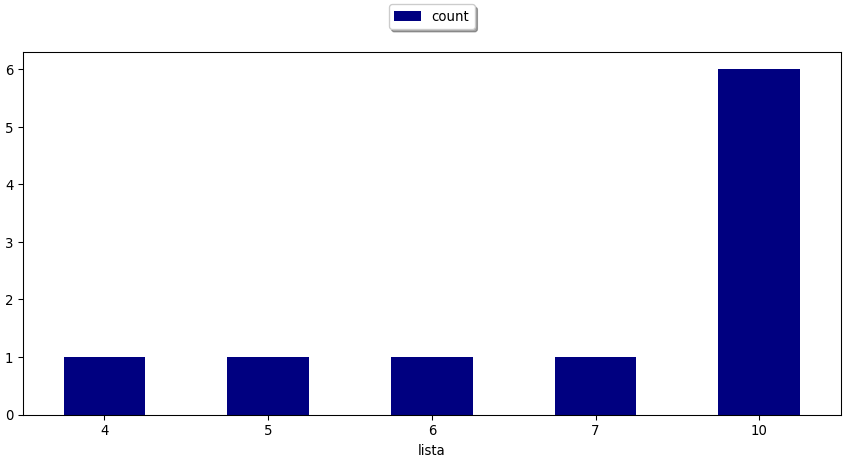

In [91]:
from pixiedust.display import *
from pyspark.sql.functions import col
counts = df.groupBy('lista').count().orderBy('count')
display(counts)

Let’s create a bar plot from this data. We’re using the pixidust library, which is Open Source, because of its simplicity. But any other library like matplotlib is fine as well. 

In [92]:
from pyspark.sql.functions import col, min, max, mean, stddev
df \
    .groupBy('lista') \
    .count() \
    .select([ 
        min(col("count")).alias('min'), 
        max(col("count")).alias('max'), 
        mean(col("count")).alias('mean'), 
        stddev(col("count")).alias('stddev') 
    ]) \
    .select([
        col('*'),
        (col("max") / col("min")).alias('minmaxratio')
    ]) \
    .show()

+---+---+----+----------------+-----------+
|min|max|mean|          stddev|minmaxratio|
+---+---+----+----------------+-----------+
|  1|  6| 2.0|2.23606797749979|        6.0|
+---+---+----+----------------+-----------+



This looks nice, but it would be nice if we can aggregate further to obtain some quantitative metrics on the imbalance like, min, max, mean and standard deviation. If we divide max by min we get a measure called minmax ration which tells us something about the relationship between the smallest and largest class. Again, let’s first use SQL for those of you familiar with SQL. Don’t be scared, we’re used nested sub-selects, basically selecting from a result of a SQL query like it was a table. All within on SQL statement.

In [107]:
spark.sql('select lista, mean(*) from df group by lista').show()

+-----+----------+
|lista|avg(lista)|
+-----+----------+
|    7|       7.0|
|    6|       6.0|
|    5|       5.0|
|   10|      10.0|
|    4|       4.0|
+-----+----------+



The same query can be expressed using the DataFrame API. Again, don’t be scared. It’s just a sequential expression of transformation steps. You now an choose which syntax you like better.

In [268]:
#list of numbers definition
import random
from pyspark.mllib.stat import Statistics
data2=(7,6,5,4,5,6,7,8,9,10)
#data2=(range(100))
rdd=sc.parallelize(data2)
rdd.take(12)

[7, 6, 5, 4, 5, 6, 7, 8, 9, 10]

Now it’s time for you to work on the data set. First, please create a table of all classes with the respective counts, but this time, please order the table by the count number, ascending.

In [269]:
#mean calculate with RDD
sum=rdd.sum()
n=rdd.count()
mean=sum/float(n)
print(mean)

6.7


Pixiedust is a very sophisticated library. It takes care of sorting as well. Please modify the bar chart so that it gets sorted by the number of elements per class, ascending. Hint: It’s an option available in the UI once rendered using the display() function.

In [270]:
#median calculate with RDD
sortedandindexed=rdd.sortBy(lambda x:x).zipWithIndex().map(lambda x:x[::-1])
n = sortedandindexed.count()
if (n % 2==1):
    index = (n-1)/2
    print ("median=",(sortedandindexed.lookup(index)))
    median=sortedandindexed.lookup(index)
else:
    index1=(n/2)-1
    index2=(n/2)
    value1=sortedandindexed.lookup(index1)[0]
    value2=sortedandindexed.lookup(index2)[0]
    print ("median=",(value1 + value2)/2)
    median=(value1 + value2)/2
print(median)

median= 6.5
6.5


Imbalanced classes can cause pain in machine learning. Therefore let’s rebalance. In the flowing we limit the number of elements per class to the amount of the least represented class. This is called undersampling. Other ways of rebalancing can be found here:

https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

In [271]:
#standard desviation calculate with RDD
from math import sqrt
sd=sqrt(rdd.map(lambda x:pow(x-mean,2)).sum()/float(n))
print(sd)

1.7916472867168916


Please verify, by using the code cell below, if df_balanced has the same number of elements per class. You should get 6683 elements per class.

In [262]:
#skewness calculate with RDD
print("n=",n)
print("mean=",mean)
print("standard desviation=",sd)
skewness=rdd.map(lambda x: pow(x-mean,3)/pow(sd,3)).sum()/float(n)
print("skewness=",skewness)

n= 10
mean= 8.8
standard desviation= 10.562196741208714
skewness= 1.4549069329914


In [263]:
#Kurtosis calculate with RDD
print("n=",n)
print("mean=",mean)
print("standard desviation=",sd)
print("skewness=",skewness)
kurtosis=rdd.map(lambda x: pow(x-mean,4)/pow(sd,4)).sum()/float(n)
print("kurtosis=",kurtosis)

n= 10
mean= 8.8
standard desviation= 10.562196741208714
skewness= 1.4549069329914
kurtosis= 3.663124005193276


In [247]:
#covariance calculate with RDD
datax=(range(100))
datay=(range(100))
rddx=sc.parallelize(datax)
rddy=sc.parallelize(datay)
meanx=rddx.sum()/float(rddx.count())
meany=rddy.sum()/float(rddy.count())
print(meanx)
print(meany)
rddxy=rddx.zip(rddy)
rddxy.take(10)

rddx.map(lambda x: (x-meanx)).map(lambda y: (y-meany)).sum()/float(rddxy.count())
print(covxy)

49.5
49.5
-49.5
